In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Appendix

# Load Library

In [0]:
import os
os.chdir('/content/drive/My Drive/bigcontest2019/fbip team/model')

In [3]:
import gc
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc
import copy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import joblib
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, folds, seed):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data.drop(columns=['acc_id', 'week']).columns
        self.true_index = defaultdict()
        self.folds = folds
        self.seed = seed
        self.model = None
    
    
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id').dropna().reset_index(drop=True)
        self.train_data = self.train_data.dropna().reset_index(drop=True)
        for week in range(1, 5):
            self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            
    def train_fs(self, params, iteration):
        self.model=model
        LABEL='survival_time'
        for idx, true in enumerate(np.unique(self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x))):
            self.true_index[true] = idx
        else:
            self.train_data[LABEL] = self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        rus = RandomUnderSampler(random_state=self.seed)
        for idx, (trn_idx, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):

            temp_train_data = pd.DataFrame()
            X, y = rus.fit_resample(self.train_data.drop(columns='survival_time'), self.train_data['survival_time'])
            temp_train_data = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], 1))
            temp_train_data.columns = self.train_data.columns
            
            trn_label = temp_train_data[LABEL]
            val_label = self.train_data.loc[val_idx, LABEL]
            train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
            valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

            lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=150, verbose_eval=1000)
            feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])
            feature_imp.to_csv('../model/feature_importance_st.csv', index=False)
            feature_imp = feature_imp.loc[feature_imp['Value']>25, 'Feature'].tolist()
            self.features_ = feature_imp
            break

    def train_st(self, params, iteration, model):
        self.model=model
        LABEL='survival_time'
            
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        rus = RandomUnderSampler(random_state=self.seed)
        for idx, (trn_idx, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):

            temp_train_data = pd.DataFrame()
            X, y = rus.fit_resample(self.train_data.drop(columns='survival_time'), self.train_data['survival_time'])
            temp_train_data = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], 1))
            temp_train_data.columns = self.train_data.columns
            
            trn_label = temp_train_data[LABEL]
            val_label = self.train_data.loc[val_idx, LABEL]
            if self.model=='lgb':
                train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
                valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

                lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=150, verbose_eval=1000)
                joblib.dump(lgb_model, "save_model_st_joblib/lgb_st_" + str(self.seed) + '_' + str(idx) + '.ckpt')
                
            elif self.model=='rf':
                rf_model = RandomForestClassifier(n_estimators=1000, random_state=self.seed, max_depth=8).fit(temp_train_data[self.features_], trn_label)
                joblib.dump(rf_model, "save_model_st_joblib/rf_st_" + str(self.seed) + '_' + str(idx) + '.ckpt')
            elif self.model=='xgb':
                train_df = xgb.DMatrix(temp_train_data[self.features_], label=trn_label)
                valid_df = xgb.DMatrix(self.train_data.loc[val_idx, self.features_], label=val_label)
                
                params = {
                    'objective': 'multi:softprob',
                    'num_class': 11,
                    'n_estimators':1000,
                    'max_depth':8,
                    'learning_rate':0.1,
                    'subsample':0.9,
                    'colsample_bytree':0.9,
                    'reg_alpha':0.1,
                    'seed':42
                }
                
                xgb_model = xgb.train(params, train_df, num_boost_round=5000, 
                          evals=[(train_df, 'train'), (valid_df, 'val')], 
                        early_stopping_rounds = 50, verbose_eval=100)
                joblib.dump(xgb_model, "save_model_st_joblib/xgb_st_" + str(self.seed) + '_' + str(idx) + '.ckpt')

    def model_load_infer_oof(self, model):
        self.model=model
        LABEL='survival_time'
        oof = np.zeros(len(self.train_data))
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)

        for idx, (_, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            if self.model=='lgb':
                lgb_model = joblib.load("save_model_st_joblib/lgb_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = np.argmax(lgb_model.predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='rf':
                rf_model = joblib.load("save_model_st_joblib/rf_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = rf_model.predict(self.train_data.loc[val_idx, self.features_])
            elif self.model=='xgb':
                xgb_model = joblib.load("save_model_st_joblib/xgb_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = xgb_model.predict(xgb.DMatrix(self.train_data.loc[val_idx, self.features_]))
                
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_survival_time'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'survival_time', 'infer_survival_time']].reset_index(drop=True)
            self.oof = oof.copy()
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:    
                self.oof['survival_time'] = self.oof['survival_time'].apply(lambda x: temp_dict[x])
                self.oof['infer_survival_time'] = self.oof['infer_survival_time'].apply(lambda x: temp_dict[x])
                return self.oof
    
    def model_load_infer_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), self.folds])
        pred2 = np.zeros([len(test2), self.folds])
        
        for idx in range(self.folds):
            if self.model=='lgb':
                lgb_model = joblib.load("save_model_st_joblib/lgb_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                pred1[:, idx] = np.argmax(lgb_model.predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(lgb_model.predict(test2[self.features_]), axis=1)
            elif self.model=='rf':
                rf_model = joblib.load("save_model_st_joblib/rf_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                pred1[:, idx] = rf_model.predict(test1[self.features_])
                pred2[:, idx] = rf_model.predict(test2[self.features_])
            elif self.model=='xgb':
                xgb_model = joblib.load("save_model_st_joblib/xgb_st_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                pred1[:, idx] = xgb_model.predict(xgb.DMatrix(test1[self.features_]))
                pred2[:, idx] = xgb_model.predict(xgb.DMatrix(test2[self.features_]))
                
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:
                for i in range(5):
                    test1[i] = test1[i].apply(lambda x: temp_dict[x])
                    test2[i] = test2[i].apply(lambda x: temp_dict[x])
                else:
                    self.pred_test1 = test1
                    self.pred_test2 = test2    
                    return self.pred_test1, self.pred_test2
    
    def load(self, return_data):
        if return_data=='train':
            return self.train_data
        elif return_data=='test1':
            return self.test1_data
        elif return_data=='test2':
            return self.test2_data
        elif return_data=='model_st':
            return self.lgb_model_st
        elif return_data=='model_tas':
            return self.lgb_model_tas
        elif return_data=='true_dict':
            return self.true_index
        elif return_data=='feature':
            return self.features_
        

if __name__ == '__main__':        
    FOLDS=5
    SEED=42
    PARAMS_ST = {
        'objective':'multiclass',
        'num_class':11,
        "boosting": "gbdt",
        'learning_rate': 0.02,
        'subsample' : 0.6,
        'sumsample_freq':1,
        'colsample_bytree':0.221856,
        'max_depth': 8,
        'max_bin':255,
        "lambda_l1": 0.25,
        "lambda_l2": 1,
        'min_child_weight': 0.2,
        'min_child_samples': 20,
        'min_gain_to_split':0.02,
        'min_data_in_bin':3,
        'bin_construct_sample_cnt':5000,
        'cat_l2':10,
        'verbose':-1,
        'nthread':-1,
        'seed':SEED
    }

    # train = pd.read_csv('../preprocess/train.csv')
    # test1 = pd.read_csv('../preprocess/test1.csv')
    # test2 = pd.read_csv('../preprocess/test2.csv')

    # train_label = pd.read_csv('../raw/train_label.csv')

    # main_model = model(train, train_label, test1, test2, FOLDS, SEED)
    # print('start main_model')

    # # survivatl time
    # main_model.labeling()
    # main_model.train_fs(PARAMS_ST, 5000)

    # # lgb
    # select_model='lgb'
    # main_model.train_st(PARAMS_ST, 5000, select_model)

    # oof_st = main_model.model_load_infer_oof(select_model)
    # oof_st.to_csv('../predict/oof_st_' + select_model + '.csv', index=False)
    # pred_st1, pred_st2 = main_model.model_load_infer_pred()
    # pred_st1.to_csv('../predict/pred_st1_' + select_model + '.csv', index=False)
    # pred_st2.to_csv('../predict/pred_st2_' + select_model + '.csv', index=False)

In [0]:
train = pd.read_csv('../preprocess/train.csv')
train_label = pd.read_csv('../raw/train_label.csv')
train_act = pd.read_csv('../raw/train_activity.csv')

In [6]:
train_act.columns

Index(['day', 'acc_id', 'char_id', 'server', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count'],
      dtype='object')

# 주차별 유저 성향

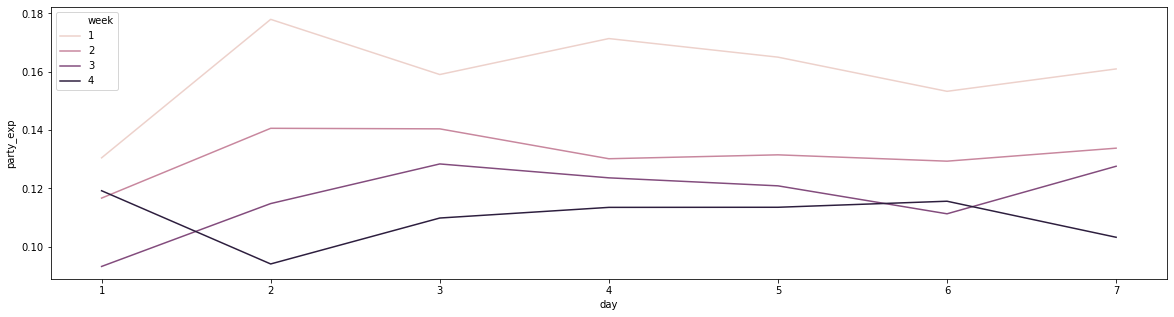

In [7]:
Y = 'party_exp'
temp_df = train_act.groupby('day')[Y].mean().reset_index()
temp_df['week'] = 0
temp_df.loc[temp_df['day']<=7, 'week'] = 1
temp_df.loc[(temp_df['day']>=8) & (temp_df['day']<=14), 'week'] = 2
temp_df.loc[(temp_df['day']>=15) & (temp_df['day']<=21), 'week'] = 3
temp_df.loc[temp_df['day']>=22, 'week'] = 4
temp_df['day'] = [int(i) for i in list('1234567'*4)]

plt.figure(figsize=(20, 5))
sns.lineplot(x='day', y=Y, data=temp_df, hue='week')
plt.show()

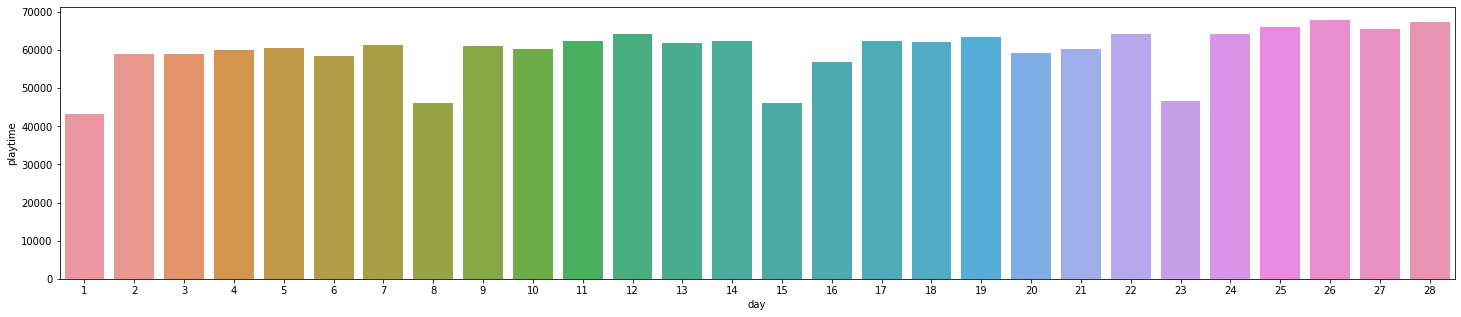

In [8]:
plt.figure(figsize=(25, 5))
sns.barplot(x='day', y='playtime', data=train_act.groupby('day')['playtime'].sum().reset_index())

# Total Amount spent

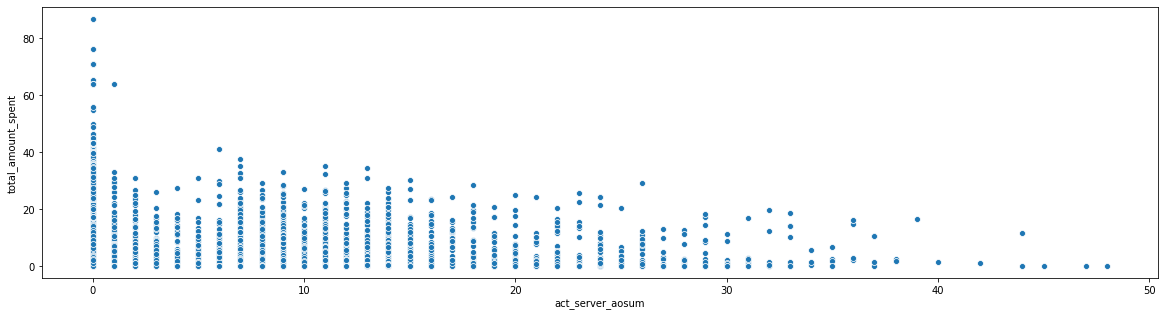

In [145]:
temp_df = main_model.load('train').copy()

plt.figure(figsize=(20, 5))
sns.scatterplot(x='act_server_aosum', y='total_amount_spent', data=temp_df)
plt.show()

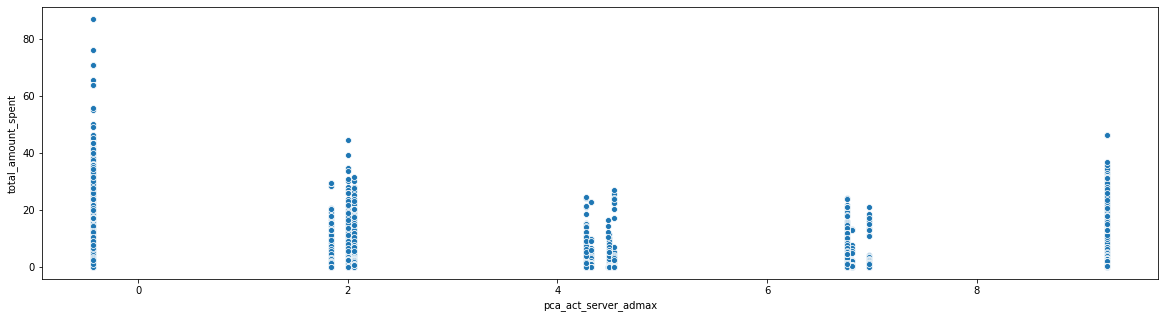

In [146]:
temp_df = main_model.load('train').copy()

plt.figure(figsize=(20, 5))
sns.scatterplot(x='pca_act_server_admax', y='total_amount_spent', data=temp_df)
plt.show()

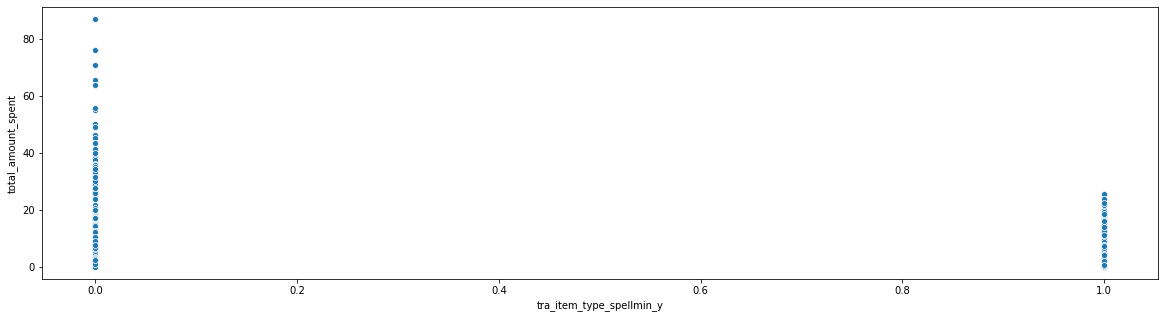

In [148]:
temp_df = main_model.load('train').copy()

plt.figure(figsize=(20, 5))
sns.scatterplot(x='tra_item_type_spellmin_y', y='total_amount_spent', data=temp_df)
plt.show()

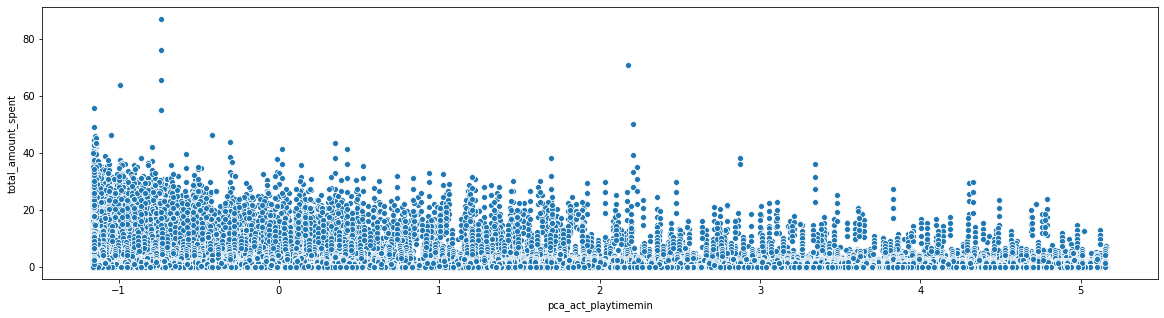

In [157]:
temp_df = main_model.load('train').copy()

plt.figure(figsize=(20, 5))
sns.scatterplot(x='pca_act_playtimemin', y='total_amount_spent', data=temp_df)
plt.show()

# Survival Time

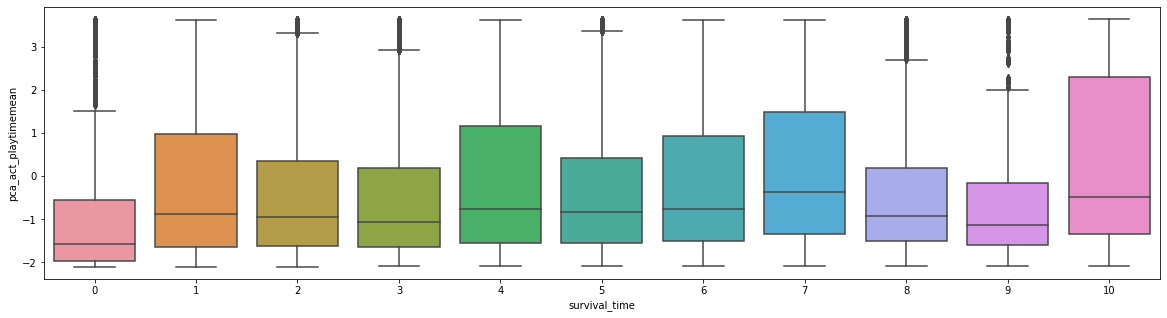

In [16]:
Y = 'pca_act_playtimemean'
temp_df = pd.merge(train[['acc_id', Y]], main_model.load('train')[['acc_id', 'survival_time']], how='left', on='acc_id')
plt.figure(figsize=(20, 5))
sns.boxplot(y=Y, x='survival_time', data=temp_df)
# plt.ylim(1.34, 1.3)
plt.show()

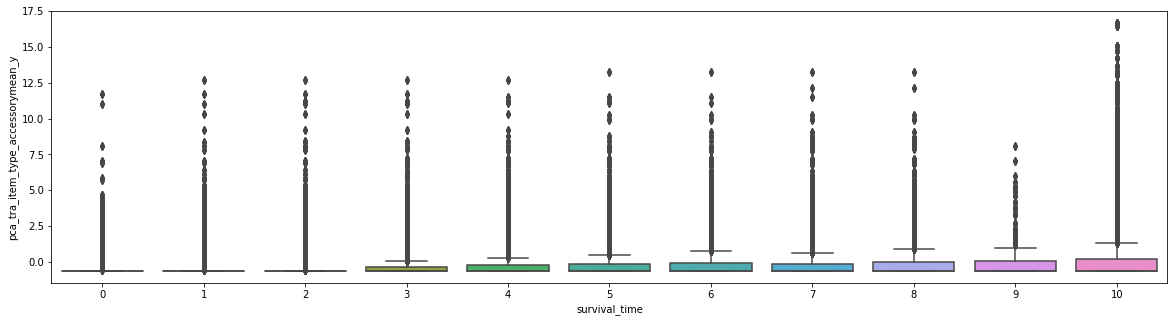

In [85]:
Y = 'pca_tra_item_type_accessorymean_y'
temp_df = pd.merge(train[['acc_id', Y]], main_model.load('train')[['acc_id', 'survival_time']], how='left', on='acc_id')
plt.figure(figsize=(20, 5))
sns.boxplot(y=Y, x='survival_time', data=temp_df)
# plt.ylim(1.34, 1.3)
plt.show()

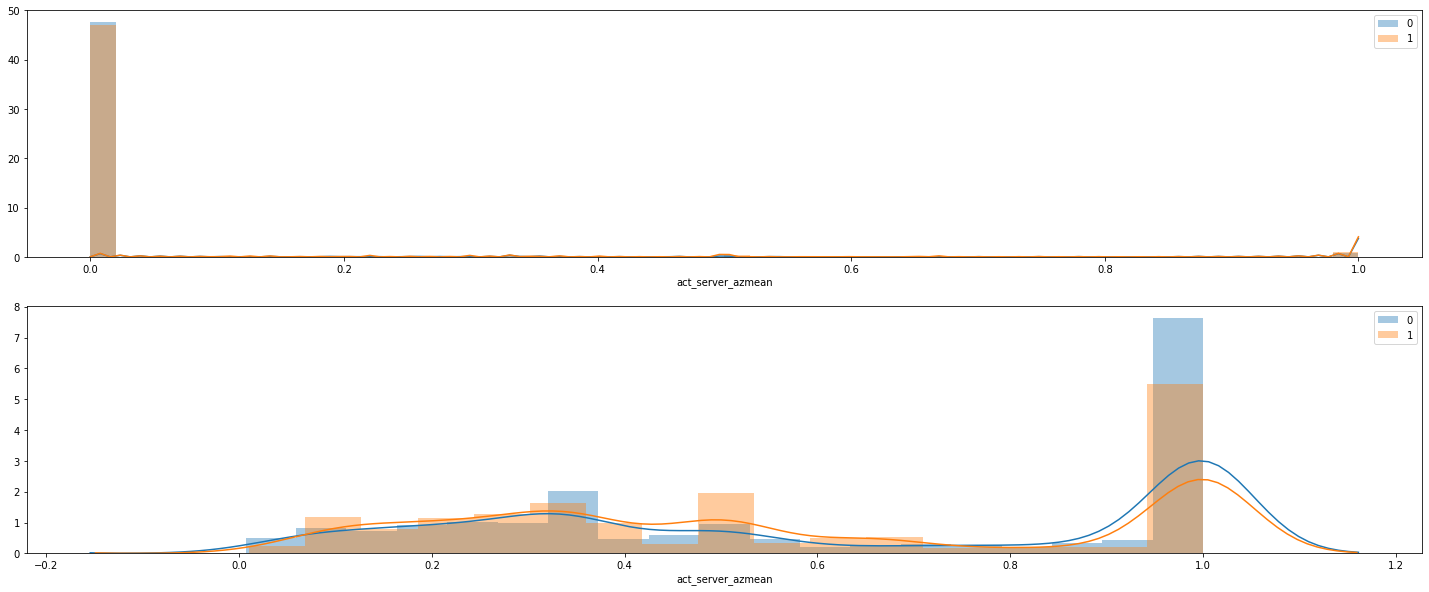

In [128]:
Y = 'act_server_azmean'
temp_df = pd.merge(train[['acc_id', Y]], main_model.load('train')[['acc_id', 'survival_time']], how='left', on='acc_id')
plt.subplots(2, 1, figsize=(25, 10))
plt.subplot(2, 1, 1)
sns.distplot(temp_df.loc[temp_df['survival_time']>=10, Y])
sns.distplot(temp_df.loc[temp_df['survival_time']<10, Y])
plt.legend([0, 1])

temp_df = temp_df[temp_df['act_server_azmean']>0]
plt.subplot(2, 1, 2)
sns.distplot(temp_df.loc[temp_df['survival_time']>=10, Y])
sns.distplot(temp_df.loc[temp_df['survival_time']<10, Y])
plt.legend([0, 1])
# plt.ylim(0, 1)
plt.show()

In [133]:
temp_df['act_server_azmean'].max()

1.0

# Class 선언

In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc
import copy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import joblib
import xgboost as xgb
import lightgbm as lgb

class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, folds, seed):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data.drop(columns=['acc_id', 'week']).columns
        self.true_index = defaultdict()
        self.folds = folds
        self.seed = seed
        self.model = None
    
    
    
    def labeling_tas(self, payment):
        self.train_data = pd.merge(self.train_data, self.train_label, how='left', on='acc_id').dropna().reset_index(drop=True)
        self.train_data['adjust_survival_time'] = self.train_data['survival_time'] + self.train_data['week']*7
        
        def payment_transform(data):
            data['week'] = (data['day']-1)//7 + 1
            data = data.groupby(['acc_id', 'week']).sum().reset_index()
            return data
        payment = payment_transform(payment)
        
        def temp_func(data):
            if data['adjust_survival_time']>64:
                over_value = data['adjust_survival_time'] - 64
                data['adjust_survival_time'] = data['survival_time'] - over_value
            else:
                data['adjust_survival_time'] = data['survival_time']
            return data['adjust_survival_time']
        
        self.train_data['adjust_survival_time'] = self.train_data[['survival_time', 'adjust_survival_time']].apply(temp_func, axis=1)
        self.train_data['payment'] = 0
        
        for week in range(1, 4):
            self.train_data.loc[self.train_data['week']==week, 'payment'] = pd.merge(self.train_data.loc[self.train_data['week']==week, 'acc_id'], 
                                                                                     payment[payment['week']>week].groupby(
                                                                                         ['acc_id'])['amount_spent'].sum().reset_index().rename(columns={'amount_spent':'payment'}), 
                                                                                     how='left', on='acc_id')['payment']
            self.train_data = self.train_data.fillna(0)
        else:
            self.train_data['total_amount_spent'] = self.train_data['amount_spent'] * self.train_data['adjust_survival_time'] + self.train_data['payment']
            self.train_data = self.train_data.drop(columns=['amount_spent', 'payment'])
            for week in range(1, 5):
                self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            else:
                self.train_data = self.train_data.drop(columns=['adjust_survival_time', 'survival_time'])
                
            
    def train_fs(self, params, iteration):
        np.random.seed(self.seed)
        LABEL='total_amount_spent'
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (trn_idx, val_idx) in enumerate(kf.split(self.train_data)):
            
            temp_list = list()
            round_basis=1;SIZE=46
            for round_value in np.round(self.train_data['total_amount_spent'], round_basis).value_counts().index:
                temp_df_index = self.train_data.loc[trn_idx, 'total_amount_spent'].index[np.round(self.train_data.loc[trn_idx, 'total_amount_spent'], round_basis).isin([round_value])]
                try:
                    temp_df_index = np.random.choice(temp_df_index, size=SIZE, replace=False)
                except:
                    pass
                temp_list.extend(temp_df_index.tolist())
            else:
                temp_train_data = self.train_data.loc[sorted(temp_list)]
                temp_train_data = temp_train_data[temp_train_data['total_amount_spent']<40].reset_index(drop=True)
                
                trn_label = temp_train_data[LABEL]
                val_label = self.train_data.loc[val_idx, LABEL]
                train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
                valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

                lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=1000, verbose_eval=3000)
                feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])            
                feature_imp.to_csv('../model/feature_importance_tas.csv')
                feature_imp = feature_imp.loc[feature_imp['Value']>25, 'Feature'].tolist()
                self.features_ = feature_imp
                break

    
    
    def train_tas(self, params, iteration, model):
        self.model=model
        np.random.seed(self.seed)
        LABEL='total_amount_spent'
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (trn_idx, val_idx) in enumerate(kf.split(self.train_data)):
            
            temp_list = list()
            round_basis=1;SIZE=46
            for round_value in np.round(self.train_data['total_amount_spent'], round_basis).value_counts().index:
                temp_df_index = self.train_data.loc[trn_idx, 'total_amount_spent'].index[np.round(self.train_data.loc[trn_idx, 'total_amount_spent'], round_basis).isin([round_value])]
                try:
                    temp_df_index = np.random.choice(temp_df_index, size=SIZE, replace=False)
                except:
                    pass
                temp_list.extend(temp_df_index.tolist())
            else:
                temp_train_data = self.train_data.loc[sorted(temp_list)]
                temp_train_data = temp_train_data[temp_train_data['total_amount_spent']<40].reset_index(drop=True)
            
                
                trn_label = temp_train_data[LABEL]
                val_label = self.train_data.loc[val_idx, LABEL]
                if self.model =='lgb':
                    train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
                    valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

                    lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=1000, verbose_eval=3000)
                    joblib.dump(lgb_model, "save_model_tas_joblib/lgb_tas_" + str(self.seed) + '_' + str(idx) + '.ckpt')
                
                elif self.model =='xgb':
                    train_df = xgb.DMatrix(temp_train_data[self.features_], label=trn_label)
                    valid_df = xgb.DMatrix(self.train_data.loc[val_idx, self.features_], label=val_label)

                    xgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds=1000, verbose_eval=3000)
                    joblib.dump(xgb_model, "save_model_tas_joblib/xgb_tas_" + str(self.seed) + '_' + str(idx) + '.ckpt')
                
                    
    def model_load_infer_oof(self, model):
        self.model=model
        LABEL='total_amount_spent'
        oof = np.zeros(len(self.train_data))
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (trn_idx, val_idx) in enumerate(kf.split(self.train_data)):
            if self.model=='lgb':
                lgb_model = joblib.load("save_model_tas_joblib/lgb_tas_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = lgb_model.predict(self.train_data.loc[val_idx, self.features_])
            elif self.model=='xgb':
                xgb_model = joblib.load("save_model_tas_joblib/xgb_tas_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                oof[val_idx] = xgb_model.predict(xgb.DMatrix(self.train_data.loc[val_idx, self.features_]))
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_total_amount_spent'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'total_amount_spent', 'infer_total_amount_spent']].reset_index(drop=True)
            self.oof_tas = oof
            return self.oof_tas
    
    def model_load_infer_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), self.folds])
        pred2 = np.zeros([len(test2), self.folds])
        
        for idx in range(self.folds):
            if self.model=='lgb':
                lgb_model = joblib.load("save_model_tas_joblib/lgb_tas_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                pred1[:, idx] = lgb_model.predict(test1[self.features_])
                pred2[:, idx] = lgb_model.predict(test2[self.features_])
            elif self.model=='xgb':
                xgb_model = joblib.load("save_model_tas_joblib/xgb_tas_" + str(self.seed) + "_" + str(idx) + ".ckpt")
                pred1[:, idx] = xgb_model.predict(xgb.DMatrix(test1[self.features_]))
                pred2[:, idx] = xgb_model.predict(xgb.DMatrix(test2[self.features_]))
        else:
            pred1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            pred2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            return pred1, pred2

    
    def load(self, return_data):
        if return_data=='train':
            return self.train_data
        elif return_data=='test1':
            return self.test1_data
        elif return_data=='test2':
            return self.test2_data
        elif return_data=='model_st':
            return self.lgb_model_st
        elif return_data=='model_tas':
            return self.lgb_model_tas
        elif return_data=='true_dict':
            return self.true_index
        elif return_data=='feature':
            return self.features_
    


if __name__ == '__main__':        
    FOLDS=5
    SEED=42
    PARAMS_TAS = {
        'objective':'regression',
        "boosting": "gbdt",
        'learning_rate': 0.02,
        'subsample' : 0.6,
        'sumsample_freq':1,
        'colsample_bytree':0.221856,
        'max_depth': 8,
        'max_bin':255,
        "lambda_l1": 0.25,
        "lambda_l2": 1,
        'min_child_weight': 0.2,
        'min_child_samples': 20,
        'min_gain_to_split':0.02,
        'min_data_in_bin':3,
        'bin_construct_sample_cnt':5000,
        'cat_l2':10,
        'verbose':-1,
        'nthread':-1,
        'metrics':'rmse',
        'seed':SEED
    }

In [0]:
main_model = model(train, train_label, pd.DataFrame(), pd.DataFrame(), 5, 42)
print('start main_model')

# survivatl time
main_model.labeling()
main_model.train_fs(PARAMS_ST, 5000)

# train_pay = pd.read_csv('../raw/train_payment.csv')
# main_model = model(train, train_label, pd.DataFrame(), pd.DataFrame(), 5, 42)
# print('start main_model')

# # total amount spent
# main_model.labeling_tas(train_pay)
# main_model.train_fs(PARAMS_TAS, 50000)

In [0]:
**PCA 영향력, 주차별 유저 행동 양식 변화량